# 第二章 基于嵌入的检索技术概述

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#一课程notebook注意事项" data-toc-modified-id="一、课程notebook注意事项">一、课程notebook注意事项</a></span></li>
        <li>
        <span><a href="#二课程内容" data-toc-modified-id="二、课程内容">二、课程内容</a></span></li><li>
        <ul class="toc-item">
            <li><span><a href="#21-系统运作原理" data-toc-modified-id="2.1 系统运作原理">2.1 系统运作原理</a></span></li>
            <li><span><a href="#22-系统具体实现" data-toc-modified-id="2.2 系统具体实现">2.2 系统具体实现</a></span></li>
        </ul>
        </li>
    </ul>
</div>

## 一、课程notebook注意事项

- 在notebook运行的过程中，可能会弹出大量的warning。这是正常现象且并不影响后续结果，可以忽略。
- 部分操作（如调用LLM或使用生成的数据集）可能产生不可预测的返回结果，因此输出结果可能和视频中不同。

## 二、课程内容
第一节课中，我们将回顾嵌入式检索系统中的一些元素，以及它们如何在一个检索增强的生成循环中与一个大型语言模型（LLM）一起配合使用。
### 2.1 系统运作原理
Chorma进行检索增强的方式是，用户请求通过用有相同嵌入的模型运行该请求来生成嵌入。
嵌入后，检索系统采用最近邻的方法找到最相关的文档。
最后把查询请求和相关文档一起交给LLM， LLM从检索到的文档中的综合信息来生成答案。
换言之，该过程就像一场开卷考试，RAG通过翻书找答案来应对提问，LLM会根据提问和RAG的参考答案来综合给出回答。

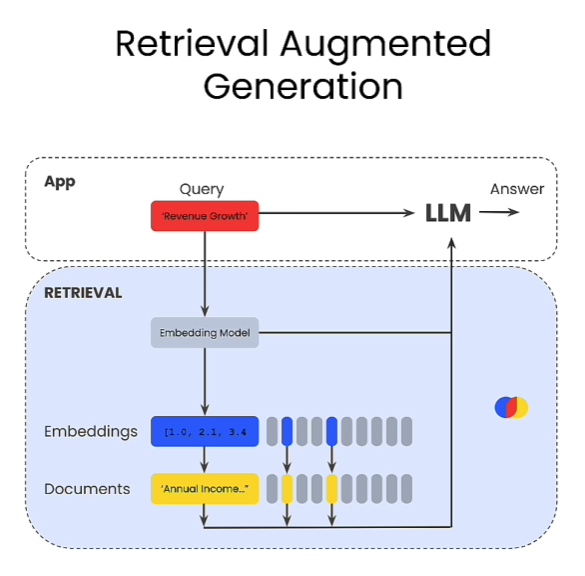


## 2.2 系统具体实现

首先，从工具库中引入一些辅助函数。helper_utils.py 文件可在当前目录中找到。
该函数是一个基础的自动换行函数，它能够以一种美观、整洁的方式查看文档。

In [1]:
from helper_utils import word_wrap

In [2]:
# 导入PDF阅读器
from pypdf import PdfReader
# 使用《北京2024年政府工作报告》作为示例文件
reader = PdfReader ("./data/北京2024年政府工作报告.pdf")
# 从该文件中提取文本，并跳过空格
pdf_texts=[p.extract_text().strip() for p in reader.pages]

# 过滤空行，因为检索系统不能接受空行
pdf_texts=[text for text in pdf_texts if text]
# 打印文档第一页作为输出示例
print(word_wrap(pdf_texts[0]))

各位代表：
现在，我代表北京市人民政府，向大会报告政府工作，请予审议，并请市政协委员提出
意见。
一、2023年工作回顾
2023年是全面贯彻落
党的二十大精神的开局之年，是三年新冠疫情防控转段后经济
恢复发展的一年。习近平总书记亲赴门头沟区看望慰问“23·7”极端强降雨受灾群众、对
灾后
复重建作出重要指示，主持召开深入推进京津冀协同发展座谈会并发表重要讲话，向
中国国际服务贸易交易会发表重要视频致辞，向中关村论坛、北京文化论坛致
信，为推动
新时代首都发展进一步指明了前进方向、提供了根本遵循。全市人民深受鼓舞、倍感振奋，
汇聚起奋进新征程、建功新时代的磅礴力量。
过去一年
在以习近平同志为核心的党中央坚强领导下，在中共北京市委直接领导下，
在市人大及其常委会监督支持下，我们坚持以习近平新时代中国特色社会主义思想为指
，
全面贯彻党的二十大和二十届二中全会精神，深入贯彻习近平总书记对北京重要讲话精神，
认真贯彻落实党中央决策部署，加强“四个中心”功能建设，提高
四个服务”水平，深化
“五子”联动服务和融入新发展格局，统筹发展和安全，着力提信心、强创新、优功能、促
协同、抓治理、惠民生，经受住多种考验，经
整体回升向好，社会大局保持稳定，各项事
业取得新进展新成效，较好完成了市十六届人大一次会议确定的目标任务。全市地区生产总
值增长5.2%、约4.
万亿元，一般公共预算收入增长8.2%、突破6000亿元，城镇调查失业
率4.4%，居民消费价格总体平稳，居民收入增长与经济增长同步，人均地区生产
值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平。
一年来，主要做了以下工作。
一是深入落实首都城市战略定位，京
冀协同发展不断走深走实。进一步优化提升首都
功能，坚持首都规划权属党中央，完善首规委工作制度，加快首都规划体系建设，深化规自
领域问题整改，严格
划执行；实施核心区控规新一轮三年行动计划，开展重点地区环境整
治提升，全力保障中央政务功能。扎实推进国际交往中心建设，雁栖湖国际会都实现扩容提

，第四使馆区等规划建设有序推进，在京登记落户国际组织机构增至115家；健全重大国
事活动服务保障常态化工作机制，圆满完成第三届“一带一路”国际合
高峰论坛服务保障
任务。深入开展疏解整治促提升专项行动，拆除违法建设2315万平方米、腾退土地2282

如果想查看该pdf文件的话，请在data目录里查找。

In [3]:
# 在LangChain工具集中，使用递归字符文本拆分器和句子转换器令牌文本拆分器。
# 字符拆分器可以根据特定的分隔符递归地划分文本，使得它可以在文本中查找指定的字符并在这些字符处将文本分割成更小的片段。
# 如果报错：SSLError:(MaxRetryEror("SOCKSHTTPSomectionpool(host='huggingface.co', port-443)，注意挂上梯子并添加以下代码：（将1080改为自己的vpn端口号）
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import os
os.environ['HTTPS_PROXY']='http://127.0.0.1:1080'
os.environ["HTTP_PROXY"]='http://127.0.0.1:1080'

In [4]:
character_splitter = RecursiveCharacterTextSplitter(
    #separators=["\n\n", "\n", ". ", " ", ""],英文文档的分割符示例
    separators=["\n\n", "\n", "。", "，", "、", "；", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

着力做好以下十一个方面工作：
（一）持续提升首都功能，推动京津冀协同发展取得新的更大进展
牢牢牵住疏解非首都功能这个“牛鼻子”，推进现代化首都都
圈建设，携手津冀共同
打造中国式现代化的先行区、示范区。
深入落实城市总体规划。严格执行首都规划重大事项向党中央请示报告制度，加快重点
街区控规
制，持续完善首都国土空间规划体系。巩固深化规自领域问题整改成效，严防“大
棚房”等问题反弹。统筹推动核心区控规三年行动计划落地见效，形成一批可视
成果，优
化提升中央政务环境和城市发展品质。
加强国际交往中心功能建设。实现新国展二期项目竣工，强化雁栖湖国际会都、奥林匹
克中心区服务保障能力
推进第四使馆区建设，提高城市环境国际化水平。积极融入、主动
服务共建“一带一路”，拓展国际友城交往。更好发挥中国国际服务贸易交易会、中关村论
坛
北京文化论坛、金融街论坛等国家级开放平台作用，吸引国际组织和机构在京落地。
打好疏解整治促提升“组合拳”。积极服务保障中央单位标志性项目向外疏解
完成第
二批市级机关搬迁。完善疏解激励约束政策体系，实现城乡建设用地再减量6.5平方公里，
确保新生违法建设动态清零。优化教育、医疗资源布局，加
首都医科大学、首都儿科研究
所通州院区等项目建设。扎实推进铁路沿线环境、城乡结合部整治和桥体绿化、留白增绿等
专项任务，精细治理背街小巷1650
，推进大红门等区域功能重塑和品质提升。
加快推进“新两翼”建设。落实北京与雄安新一轮战略合作协议，推动政务服务同城化，
深化“三校一院”办学办医
作，共同建好雄安新区中关村科技园。加快城市副中心高质量
发展步伐，继续保持千亿级投资强度，启动东六环高线公园建设，实现副中心站综合交通枢
纽主体
程基本完工、东六环入地改造项目具备通车条件，实施轨道交通101线、22号线
等重大项目，实现厂通路建成通车。谋划推进环球主题公园二期，加快建设潮
河国家森林
公园，推动“两个示范区”建设取得更大突破。
深化协同创新和产业协作。积极推进京津冀国家技术创新中心建设，引导支持三地创新
主体共建成
孵化与中试基地。加快“六链五群”产业布局，“一链一策”开展产业链延伸
和协同配套。着力打造京冀曹妃甸协同发展示范区、京张体育文化旅游带，推动燃料
池汽
车示范城市群建设。唱好京津“双城记”，抓好天津滨海-中关村科技园等合作园区建设。

Total 

In [5]:
# 创建分词器实例，假设可以通过某种方式传入model实例
# 这里的代码需要根据实际的API和参数进行调整
# 为了适应中文文档的要求，这里指定多语言模型 all-mpnet-base-v2 其初始化格式如下：
# __init__(chunk_overlap: int = 50, model_name: str = 'sentence-transformers/all-mpnet-base-v2', tokens_per_chunk: Optional[int] = None, **kwargs: Any) → None
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0,model_name='sentence-transformers/paraphrase-xlm-r-multilingual-v1', tokens_per_chunk=128)

token_split_texts = []
# for text in preprocessed_texts:
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

进展,一批创新药品、 医疗器械获批上市,小米智能手机工厂、理想汽车旗舰工厂提前投产。精心打造全球数字经
济标杆城市,率先建成全球性能领先的区块链基础设施,新增5G基站3万个,获准向公众
开放的生成式人工智能大模型产品占全国近一半,“京通”“京办”“京智”三个智慧城市应
用终端快速升级拓展,高级别自动驾驶示范区实现160平方公里连片运行,全国首个数据基 础制度先行区启动建设,数字经济增加值占地区生产总值比

Total chunks: 102


上下文窗口大小限制是一个小陷阱。没有处理过嵌入可能会忽略嵌入模型上下文窗口大小限制。上下文窗口大小很关键，一个嵌入模型固定的上下文窗口大小规定了在给定时间内能够考虑的一定数量的词。也就是模型能够“看到”和处理的文本长度。如果文本超过了模型的上下文窗口大小，模型可能无法捕捉到超出窗口范围的文本信息，这可能会影响嵌入的质量和最终的检索或生成结果的准确性。

In [8]:
# 使用BERT来实现句子转换器
# 句子转换器是出色的嵌入模型，内置于 Chorma 中，开源且所有权重可在线获取。
# 下面的工作是为了创建一个句子转换器嵌入函数，使其能够和 Chorma 一起使用。
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai_api_key = os.environ['OPENAI_API_KEY']

# chromadb支持的嵌入函数有许多种，这里介绍常用的几种：
# 参考资料：https://docs.trychroma.com/embeddings

# 方式1：默认嵌入函数，需要下载模型，本地计算。英文文本表现不错，中文文本表现一般
# embedding_function = SentenceTransformerEmbeddingFunction()

# 方式2：OpenAI的嵌入函数，直接调用OpenAI的接口，无需下载模型（推荐）
embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                api_key=openai_api_key,
                model_name="text-embedding-ada-002"
            )

# 方式3：HuggingFace的嵌入函数，需要下载模型，本地计算，对网络要求高
# embedding_function = embedding_functions.HuggingFaceEmbeddingFunction(
#     api_key="hf_",  # 填入你的 huggingface Access Token
#     model_name="jinaai/jina-embeddings-v2-base-zh"  # 指定模型
# )
## 中文备选模型
# jinaai/jina-embeddings-v2-base-zh
# GanymedeNil/text2vec-large-chinese
# BAAI/bge-large-zh-v1.5
# BAAI/bge-small-zh-v1.5

# print(embedding_function([token_split_texts[10]]))

In [9]:
# 接下来是设置Chroma
chroma_client = chromadb.Client()
# 注意这里的名称（beijing_annual_report_2024）可以自己定义，但要求格式是str
chroma_collection = chroma_client.create_collection("beijing_annual_report_2024", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

102

In [10]:
# 现在所有内容都加载到了Chorma中，让我们连接一个LLM并构建一个完整的检索增强生成（RAG)系统
# 接下来演示查询、检索和LLM是如何一起工作的
query = "财政总收入是多少?"

# 查询Chorma来获取结果，请求5个结果
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print('\n')

基层执法能力和规范化水平。持之以恒改进 作风,压减一般性支出和非紧急非刚性支出23.9亿元,“三公”经费减少5%;深化全成本
预算绩效管理改革,推动市区街成本绩效管理全覆盖,实现经营性国有资产集中统一监管;
重点纠治形式主义、官僚主义,扎实推进精文简会和基层减负工作;加大审计监督、财会监
督力度,完成首轮统计督察,以严的基调强化正风肃纪反腐,清廉守正、求真


、劳有 所得。持续增加城乡居民收入,扩大中等收入群体规模。


,加强“四个中心”功能建设,提高“四个服务”水平,深化 “五子”联动服务和融入新发展格局,统筹发展和安全,着力提信心、强创新、优功能、促
协同、抓治理、惠民生,经受住多种考验,经济整体回升向好,社会大局保持稳定,各项事
业取得新进展新成效,较好完成了市十六届人大一次会议确定的目标任务。全市地区生产总
值增长5.2%、约4.4万亿元,一般公共预算收入增长8.2%、突破6000亿元,城镇调查失业


率4.4%,居民消费价格总体平稳,居民收入增长与经济增长同步,人均地区生产总值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平。 一年来,主要做了以下工作。
一是深入落实首都城市战略定位,京津冀协同发展不断走深走实。进一步优化提升首都
功能,坚持首都规划权属党中央,完善首规委工作制度,加快首都规划体系建设,深化规自
领域问题整改,严格规划执行;实施核心区控规新一轮三年行动计划,


”规划,提出今年全市经济社 会发展的主要预期目标是:地区生产总值增长5%左右,一般公共预算收入增长5%,城镇调
查失业率控制在5%以内,居民消费价格涨幅3%左右,居民收入增长与经济增长同步,生态 环境质量、能源、水资源等指标达到国家要求。
实现以上目标,既有有利的因素和条件,也面临不少困难和挑战。我们要坚定信心、迎




In [12]:
# 接下来，将这些结果与LLM一起使用，来回答查询
# 使GPT进行操作，以便拥有一个OpenAI客户端
# 在此之前需要在当前目录中创建
import os
import openai
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv
# 在当前目录下创建.env文件（注意该文件没有后缀名）
# 文件内容为 OPENAI_API_KEY="sk-"（引号部分是自己的openai_api_key,通过登录openai官网，找到API keys就可以查询)
_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [13]:
# 使用GPT3.5 Turbo完成后续操作
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)
    
# 英文prompt
#   messages = [
#        {
#           "role": "system",
#           "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
#           "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
#       },
#        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
#   ]

# 中文prompt
    messages = [
        {
            "role": "system",
            "content": "你是一个有用的专家级财务研究助手。你的用户正在询问年度报告中包含的信息相关的问题。"
                       "你将看到用户的问题和年度报告中的相关信息。请仅使用这些信息回答用户的问题。"
        },
        {"role": "user", "content": f"问题：{query}。\n信息：{information}"}
    ]
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [18]:
# 得到最终的回答
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

根据年度报告中的信息，一般公共预算收入达到了6000亿元，增长了8.2%。所以，财政总收入为6000亿元。
